# Comparing FF to PC Weights
Purpose:
- To investigate the relationship between weights generated by:
   1. FF + Backprop, with weight decay
   2. PC with weight decay
- I hypothesize that they will produce very similar weights (compared to not including weight decay for at least one of them).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
dtype = torch.float
device = torch.device("cpu")
import NeuralNetwork as NN
import FFNetwork as FF
import Layer
import importlib
import time
from IPython.display import display
from ipywidgets import FloatProgress
from copy import deepcopy
importlib.reload(NN)
importlib.reload(FF)
importlib.reload(Layer);

In [2]:
def ClassPlot(x, labels=[], idx=(1,2)):
    # FeedForward
    #yc = Network.OneHot(y)
    if len(labels)>0:
        colour_options = ['y', 'r', 'g', 'b', 'k']
        cidx = np.argmax(labels, axis=1)
        colours = [colour_options[k] for k in cidx]
        plt.scatter(x[:,idx[0]], x[:,idx[1]], color=colours, marker='.')
    else:
        plt.scatter(x[:,idx[0]], x[:,idx[1]], marker='.')
    plt.axis('equal');

In [3]:
def cosine_proximity(M1, M2):
    return np.sum(M1*M2) / np.linalg.norm(M1.flatten()) / np.linalg.norm(M2.flatten())

## Create a simple dataset

In [4]:
# This creates a dataset

n_classes = 3
#hidden_dim = 5
sensory_dim = 5

seed = 2610
torch.manual_seed(seed)
np.random.seed(seed)
B = np.eye(n_classes)
X = 3.*(np.random.rand(sensory_dim, n_classes) - 0.5)
A = X.T
print('Bottom vectors')
print(B)
print('Top vectors')
print(A)
#print('System matrix:\n'+str(M))

Bottom vectors
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Top vectors
[[-0.48932516  0.13014042  1.4684664   0.48737025  0.72496988]
 [-1.2323579  -1.16497735  0.56182042 -1.46463011  0.16859907]
 [-1.22924953 -0.43436831  1.13980164 -1.40424674 -0.86098236]]


In [5]:
# Use A and B to make a dataset
def MakeDataset(A, B, n=300, noise=0.2, seed=None):
    n_classes, top_dim = np.shape(A)
    bottom_dim = n_classes

    if seed!=None:
        np.random.seed(seed)
    training_samples = n
    #noise = 0.2
    training_input = []
    training_output = []
    for n in range(training_samples):
        r = np.random.randint(n_classes)
        training_input.append(B[r])
        training_output.append(A[r]+noise*np.random.normal(size=np.shape(A[r])))

    training_input = torch.tensor(training_input).float().to(device)
    training_output = torch.tensor(training_output).float().to(device)
    train = [training_input, training_output]
    return train

In [73]:
train = MakeDataset(A, B, noise=0.1)

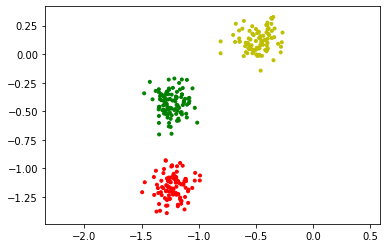

In [74]:
ClassPlot(train[1], labels=train[0], idx=(0,1))

# FF + Backprop

In [29]:
lr = 0.01   # learning rate
Wdecay = 0.0007  # weight decay
af = 'identity'
mid_af = 'logistic'
mult = 4.

In [38]:
# Create a network
ffnet = FF.Network()
ffnet.AddLayer(FF.Layer(n_nodes=sensory_dim, act=af))
#ffnet.AddLayer(FF.Layer(n_nodes=hidden_dim, act=mid_af))
ffnet.AddLayer(FF.Layer(n_nodes=n_classes, act=af))
ffnet.SetCostFunction('MSE')

In [47]:
# Train a bunch, and record the weight matrices
# One trial's matrix in each col
n_trials = 10
Wff_decay = []
total_accuracy = 0.
for trial in range(n_trials):
    train = MakeDataset(A, B, noise=0.02)
    ffnet.RandomWeights(mult=mult)
    ffnet.SGD(train[1].numpy(), train[0].numpy(), lrate=lr, epochs=500, batch_size=30, decay=0.000, progress=1000)
    total_accuracy += FF.ClassificationAccuracy(ffnet.FeedForward(train[1].numpy()), train[0].numpy())
    Wff_decay.append(ffnet.W[0].flatten())
Wff_decay = np.array(Wff_decay).T
print('Accuracy = '+str(np.round(total_accuracy/n_trials*100, 2))+'%')

Accuracy = 100.0%


# PC

In [58]:
pcnet = NN.NeuralNetwork()
pcnet.AddLayer(Layer.InputPELayer(n=n_classes))
pcnet.AddLayer(Layer.TopPELayer(n=sensory_dim))
pcnet.Connect(0,1, act='identity', symmetric=True)
pcnet.SetTau(0.02)
pcnet.learning_tau = 0.08
pcnet.learning_biases = False
pcnet.SetWeightDecay(0.0)

identity


In [72]:
pcnet.connections[0].RandomWeights(mult=4.)
print(pcnet.connections[0].M.numpy().flatten())

[ 2.8257356   3.4464583   0.7688192  -1.6656151   2.9990573   1.8191041
  1.9554667   1.521227   -4.569532    0.793448   -2.5765266   2.323524
  0.24919514 -2.7373414   0.6627047 ]


In [80]:
progress = pcnet.Learn(train[0], train[1], T=2., dt=0.001, epochs=10, batch_size=30, turn_down_lam=0.8, learning_delay=0.5)

FloatProgress(value=0.0, max=3000.0)

/Users/jorchard/Dropbox/research/peBogacz/peBogacz/python/NeuralNetwork.py:998: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c.lam = torch.tensor(w_decay).float().to(device)


turning down weight-decay and v-decay by a factor of 0.8


/Users/jorchard/Dropbox/research/peBogacz/peBogacz/python/NeuralNetwork.py:994: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  l.v_decay = torch.tensor(v_decay).float().to(device)


turning down weight-decay and v-decay by a factor of 0.8
turning down weight-decay and v-decay by a factor of 0.8
turning down weight-decay and v-decay by a factor of 0.8
turning down weight-decay and v-decay by a factor of 0.8
turning down weight-decay and v-decay by a factor of 0.8
turning down weight-decay and v-decay by a factor of 0.8
turning down weight-decay and v-decay by a factor of 0.8
turning down weight-decay and v-decay by a factor of 0.8
turning down weight-decay and v-decay by a factor of 0.8


In [70]:
M0 = deepcopy(pcnet.connections[0].M)

In [81]:
M1 = deepcopy(pcnet.connections[0].M)

In [82]:
cosine_proximity(M0.numpy(), M1.numpy())

0.9958406

In [90]:
pcnet.layers[0].Probe(True)
y = pcnet.Generate(1., train[1][50], dt=0.001)

tensor([[0.0107, 0.0354, 0.9540]])


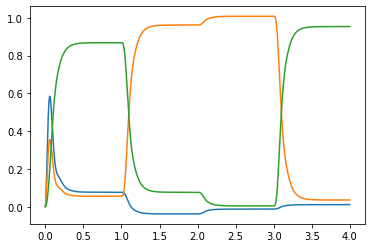

In [91]:
plt.plot(pcnet.t_history, pcnet.layers[0].v_history)
print(y)

In [14]:
print(pcnet.connections[0].M.numpy().flatten())
print(Wpc_decay)

[ 0.1251281  -0.00230495 -0.1228209   0.12979352 -0.3150377   0.18524204
  0.12519918 -0.32086402  0.19566329  0.30033866 -0.24005033 -0.06028664
  0.12757121  0.41837224 -0.54594487]
[[ 0.1039052   0.10467371  0.1251281 ]
 [-0.10239168 -0.12346913 -0.00230495]
 [-0.00151403  0.01879672 -0.1228209 ]
 [ 0.20379193  0.1503461   0.12979352]
 [-0.45521125 -0.3600801  -0.3150377 ]
 [ 0.251421    0.20973395  0.18524204]
 [ 0.06085494  0.05746156  0.12519918]
 [-0.30055735 -0.34356132 -0.32086402]
 [ 0.23970357  0.28609818  0.19566329]
 [ 0.27254847  0.30232754  0.30033866]
 [-0.15910926 -0.23508349 -0.24005033]
 [-0.11344149 -0.06724369 -0.06028664]
 [ 0.17658758  0.17553169  0.12757121]
 [ 0.40780318  0.4531398   0.41837224]
 [-0.584388   -0.62867194 -0.54594487]]


In [50]:
# Train a bunch, and record the weight matrices
# One trial's matrix in each col
n_trials = 10
Wpc_decay = []
total_accuracy = 0.
for trial in range(n_trials):
    train = MakeDataset(A, B, noise=0.05)
    pcnet.connections[0].RandomWeights(mult=mult)
    pcnet.Learn(train[0], train[1], T=5., dt=0.001, epochs=5, batch_size=50)
    Wpc_decay.append(deepcopy(pcnet.connections[0].M.numpy().flatten()))
    print(pcnet.connections[0].M.numpy().flatten())
Wpc_decay = np.array(Wpc_decay).T

FloatProgress(value=0.0, max=1500.0)

[ 0.06390969  0.13071367 -0.0818902   0.1420567  -0.51239616  0.35077474
  0.11875676 -0.67944384  0.2929535   0.2863658   0.03167783 -0.17953
  0.18256855  0.21249504 -0.5599976 ]


FloatProgress(value=0.0, max=1500.0)

[-0.05812959  0.16728495 -0.03136272  0.01669898 -0.31406453  0.22361512
  0.47183546 -0.76116115  0.40542534  0.217724   -0.08823312 -0.16575085
  0.2956529   0.3042341  -0.5882053 ]


FloatProgress(value=0.0, max=1500.0)

[ 0.13438065 -0.01871789  0.15450686  0.07670242 -0.48497352  0.20214988
  0.07927359 -0.32326224  0.07300204  0.33976147 -0.1353863  -0.0158053
  0.11117707  0.41228864 -0.76142025]


FloatProgress(value=0.0, max=1500.0)

[ 0.06131356 -0.24784735 -0.0542812   0.05043737 -0.4606845   0.30012485
  0.17650016  0.03983894  0.18761407  0.33290923 -0.30943123 -0.08562424
  0.1550637   0.6275777  -0.64480644]


FloatProgress(value=0.0, max=1500.0)

[ 0.24942152  0.04524472 -0.08939362  0.12800017 -0.48917425  0.21142696
  0.11267308 -0.27745783  0.3633043   0.23767366 -0.19276251 -0.11425055
  0.16755876  0.45479494 -0.6217294 ]


FloatProgress(value=0.0, max=1500.0)

[ 0.00695771  0.26860353 -0.07980973  0.05333892 -0.41890147  0.2706067
  0.37684384 -0.7076729   0.17162156  0.23151097 -0.09857626 -0.01994631
  0.2499271   0.27401978 -0.68346715]


FloatProgress(value=0.0, max=1500.0)

[ 0.22325122 -0.11219276 -0.09248447  0.21301542 -0.38315228  0.26567543
 -0.17702635 -0.32821408  0.4095483   0.34410238 -0.19911359 -0.17603649
  0.07413919  0.49431092 -0.55449986]


FloatProgress(value=0.0, max=1500.0)

[ 0.19948462 -0.1629133  -0.36331213  0.21097866 -0.40415308  0.32606086
 -0.03681604 -0.05731498  0.5637392   0.2690815  -0.3206226  -0.22690782
  0.13986844  0.61320555 -0.3987438 ]


FloatProgress(value=0.0, max=1500.0)

[ 0.21447311 -0.2711681   0.13718961  0.2028842  -0.43682724  0.28440782
 -0.10931744 -0.25444853  0.11037209  0.31307834 -0.14210846 -0.08922168
  0.10571857  0.5028135  -0.71260905]


FloatProgress(value=0.0, max=1500.0)

[ 0.09646002 -0.11162771 -0.00622808  0.22464697 -0.41452885  0.25549698
 -0.03970599 -0.40390718  0.4305975   0.29856864 -0.12853329 -0.2118071
  0.15327917  0.4445691  -0.5595253 ]


## Let's look at how similar the weight matrices are.

In [ ]:
pcnet.connections[0].lam

In [ ]:
cosine_proximity(Wff_decay[:,0], Wff_decay[:,1])

In [ ]:
cosine_proximity(Wpc_decay[:,0], Wpc_decay[:,1])

In [ ]:
cosine_proximity(Wpc_decay[:,1], Wff_decay[:,0])

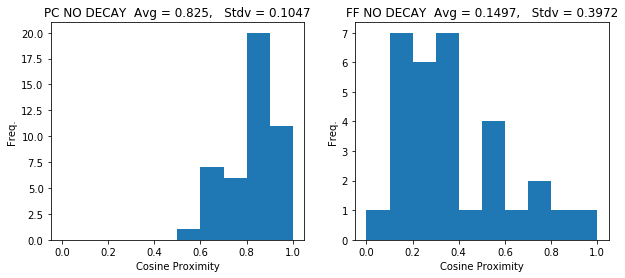

In [51]:
# Statistics of Cosine Proximity
titles = ['PC NO DECAY', 'FF NO DECAY']
plt.figure(figsize=(10,4))
for k,blah in enumerate([Wpc_decay, Wff_decay]):
    cp = []
    WsT = blah.T
    for i,w1 in enumerate(WsT):
        for j,w2 in enumerate(WsT[i+1:]):
            cp.append(cosine_proximity(w1,w2))
    cp = np.array(cp)

    plt.subplot(1,2,k+1)
    plt.hist(cp, range=[0,1]);
    plt.xlabel('Cosine Proximity'); plt.ylabel('Freq.');
    plt.title(titles[k]+'  Avg = '+str(np.round(np.mean(cp),4))+',   Stdv = '+str(np.round(np.std(cp),4)))


In [44]:
Wff_decay

array([[-1.02805312,  1.00699669, -1.02078197, -1.06951588,  0.2426195 ,
         0.35069492, -0.6185158 , -0.59740512, -1.45404849,  1.02903678],
       [-1.93068357, -1.188911  ,  0.7662509 ,  1.25131844,  0.88820354,
        -1.0629867 , -0.11947493,  0.20707774, -0.12698078,  0.06195327],
       [ 0.61290717, -0.85243702, -0.28183603,  0.6795169 , -0.49054828,
         0.56482445,  0.38076532, -0.5075524 ,  0.74827735,  1.36903304],
       [ 1.11467275, -0.11986982,  0.34846331,  0.65532358,  0.04962332,
        -0.50065485,  1.21612041,  0.63752767, -0.45743508, -0.31555886],
       [ 1.1741084 ,  0.26322965, -0.60092667, -1.73473318, -0.45675541,
         0.07973751, -0.63333527, -1.99138287, -0.43461011, -0.6170191 ],
       [ 1.1916147 ,  0.58044342,  0.5762677 , -0.67372378, -0.06739373,
        -0.56611151, -0.58370646, -0.16890856,  0.94297911,  0.24188684],
       [-0.13029451,  0.90992417, -0.02507973, -0.07511028,  0.57841012,
         0.68435417,  0.05922771,  0.11893049